# MUFGコンペティション データ理解・前処理方針策定ノートブック

このノートブックでは、データの理解を深め、前処理方針を明確化するための分析を行います。各分析セルにはコメントを記載しています。

In [14]:
# 必要なライブラリのインポートとシード値の固定
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import random


# 再現性のためのシード値固定
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

In [15]:
# データの読み込み
# ファイルパスの設定
train_path = '../data/raw/train.csv'
test_path = '../data/raw/test.csv'
sample_submit_path = '../data/raw/sample_submit.csv'
description_path = '../prompt/description.txt'

# CSVデータの読み込み
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)
sample_submit = pd.read_csv(sample_submit_path, header=None)

# description.txtの読み込み
with open(description_path, encoding='utf-8') as f:
    description = f.read()

print('train shape:', train.shape)
print('test shape:', test.shape)
print('sample_submit shape:', sample_submit.shape)

train shape: (7552, 16)
test shape: (7552, 15)
sample_submit shape: (7552, 2)


## description.txtを参考にしたデータ辞書

| ヘッダ名称 | 値例 | データ型 | 説明 |
|---|---|---|---|
| id | 0 | int64 | データID |
| GrossApproval | 23000 | int64 | 融資承認額（総額） |
| SBAGuaranteedApproval | 7093 | int64 | 融資額の補償金額 |
| ApprovalFiscalYear | 2020 | int64 | 融資承認年度 |
| Subprogram | FA$TRK (Small Loan Express) | str | ローンの種類 |
| InitialInterestRate | 11.92 | float64 | 初期金利 |
| FixedOrVariableInterestInd | V | str | 固定金利(F)または変動金利(V) |
| TermInMonths | 84 | int64 | 融資期間（月単位） |
| NaicsSector | Accommodation_food services | str | 産業の大分類 |
| CongressionalDistrict | 27 | int | 借入者の住所が属する選挙区 |
| BusinessType | CORPORATION | str | 借入者の事業形態 |
| BusinessAge | Unanswered | str | 事業の年数区分 |
| RevolverStatus | 0 | int64 | 定期貸付（0）かリボルビング（1）か |
| JobsSupported | 1 | int64 | 借入者事業者の雇用数（借入者の自己申告） |
| CollateralInd | N | str | 担保の有無（借入者の自己申告） |
| LoanStatus | 1 | int64 | ローンの状態（目的変数: 1 = デフォルト, 0 = デフォルトしていない） |

In [16]:

print('学習データのユニーク値数:')
print(train.nunique())
print('テストデータのユニーク値数:')
print(test.nunique())

学習データのユニーク値数:
id                            7552
GrossApproval                 4840
SBAGuaranteedApproval         7423
ApprovalFiscalYear               5
Subprogram                       9
InitialInterestRate           1252
FixedOrVariableInterestInd       2
TermInMonths                   245
NaicsSector                     19
CongressionalDistrict           53
BusinessType                     4
BusinessAge                      5
RevolverStatus                   2
JobsSupported                  195
CollateralInd                    2
LoanStatus                       2
dtype: int64
テストデータのユニーク値数:
id                            7552
GrossApproval                 4725
SBAGuaranteedApproval         7418
ApprovalFiscalYear               5
Subprogram                       9
InitialInterestRate           1236
FixedOrVariableInterestInd       2
TermInMonths                   237
NaicsSector                     20
CongressionalDistrict           53
BusinessType                     4
BusinessAge  

In [17]:
# 特徴量ごとの基礎統計量の算出
print('数値特徴量の統計量:')
display(train.describe())




数値特徴量の統計量:


,id,GrossApproval,SBAGuaranteedApproval,ApprovalFiscalYear,InitialInterestRate,TermInMonths,CongressionalDistrict,RevolverStatus,JobsSupported,LoanStatus
count,7552.000000,7.552000e+03,7.552000e+03,7552.000000,7552.000000,7552.000000,7552.000000,7552.000000,7552.000000,7552.000000
mean,3776.500000,7.219039e+05,4.536842e+05,2021.091499,7.379586,119.854211,12.681674,0.115731,14.281912,0.127648
std,2180.218949,1.112669e+06,7.805103e+05,1.125885,2.884902,82.423821,12.307653,0.319923,27.635214,0.333720
min,1.000000,5.000000e+03,2.500000e+03,2020.000000,1.030000,3.000000,0.000000,0.000000,0.000000,0.000000
25%,1888.750000,5.110000e+04,2.653525e+04,2020.000000,5.120000,60.000000,3.000000,0.000000,1.000000,0.000000
50%,3776.500000,1.896000e+05,1.063350e+05,2021.000000,6.610000,119.000000,7.000000,0.000000,5.000000,0.000000
75%,5664.250000,8.113000e+05,4.669272e+05,2022.000000,9.550000,120.000000,22.000000,0.000000,14.000000,0.000000
max,7552.000000,4.995000e+06,4.311817e+06,2024.000000,15.000000,306.000000,52.000000,1.000000,236.000000,1.000000


# 目的変数について
目的変数は `LoanStatus` で、1がデフォルト、0がデフォルトしていないことを示します。この変数は、融資のリスクを評価するための重要な指標です。
デフォルトとは、債務不履行のこと。
債券の元利払いや償還ができなくなるなど、債務者が故意や過失により債務の本旨に従った履行をしないことで、英語の「default」の日本語読みです。債務不履行は、履行が遅れる「履行遅延」、履行することができなくなった「履行不能」、履行したが不十分だった「不完全履行」の3種類に分類されます。

LoanStatus 件数:
LoanStatus
0    6588
1     964
Name: count, dtype: int64

LoanStatus 割合:
LoanStatus
0    0.872352
1    0.127648
Name: proportion, dtype: float64


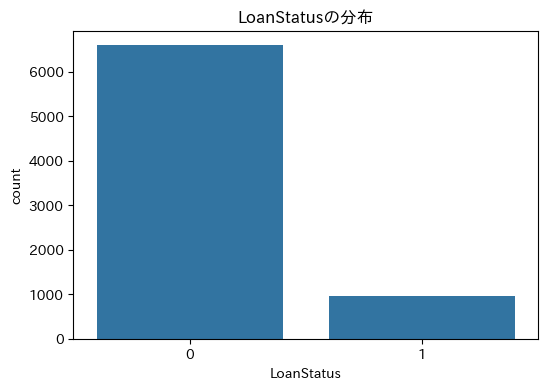

In [18]:
# 目的変数（LoanStatus）の分布確認
loan_status_counts = train['LoanStatus'].value_counts()
loan_status_ratio = train['LoanStatus'].value_counts(normalize=True)
print('LoanStatus 件数:')
print(loan_status_counts)
print('\nLoanStatus 割合:')
print(loan_status_ratio)

plt.figure(figsize=(6,4))
sns.countplot(x='LoanStatus', data=train)
plt.title('LoanStatusの分布')
plt.show()

# 特徴量の理解


## 数値特徴量

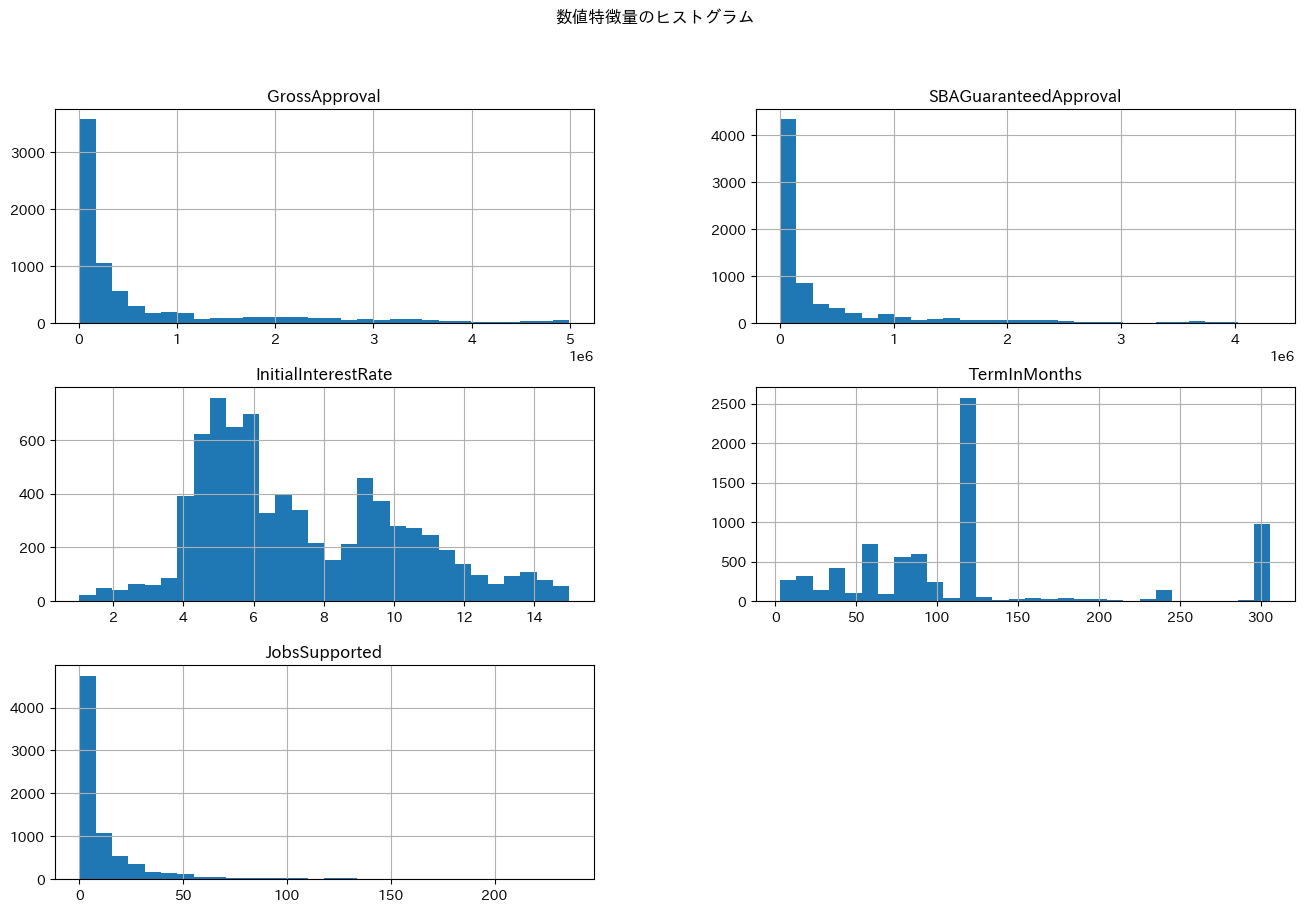

In [19]:
# 数値特徴量のみを抽出
num_cols = train.select_dtypes(include=[np.number]).columns.drop(['LoanStatus', 'id', 'RevolverStatus', 'ApprovalFiscalYear', 'CongressionalDistrict']).tolist()

# 数値特徴量のヒストグラム
train[num_cols].hist(figsize=(16,10), bins=30)
plt.suptitle('数値特徴量のヒストグラム')
plt.show()

# それぞれの数値特徴量について、ビンごとにn数を算出し、CSVに保存
for col in num_cols:
    bin_counts = train[col].value_counts(bins=30)
    bin_counts_df = pd.DataFrame(bin_counts).reset_index()
    bin_counts_df.columns = ['bin', 'count']
    bin_counts_df['feature'] = col
    bin_counts_df.to_csv(f'../data/understand/bin_counts/{col}_bin_counts.csv', index=False)






## カテゴリ特徴量の分布と意味

<details>
<summary>カテゴリ特徴量の分布と意味</summary>

### Subprogram: ローンの種類（値は9種類）

---

#### 🔹 FA$TRAK (Small Loan Express)
- **概要**: かつて存在したSBAの簡易・迅速なローン保証プログラム。小規模融資（最大$350,000）に対して、銀行が迅速に承認できるようにしていた。
- **特徴**: 従来の7(a)ローンよりも申請書類が簡略化され、迅速な資金提供が可能。
- **現状**: 現在はSBA Expressなどに統合された形で存在している場合あり。

---

#### 🔹 Guaranty
- **概要**: SBAが直接融資するのではなく、民間銀行などの融資に対して保証（guaranty）を行う制度。
- **意義**: 借入者が返済不能になった場合、SBAが一定割合（通常50～85％）を保証。金融機関にとってリスク軽減になる。

---

#### 🔹 Community Advantage Initiative
- **概要**: 地域密着型金融支援として、SBAが2011年に導入した試験的プログラム。
- **目的**: 信用履歴や担保が十分でない低所得層・マイノリティ・地方中小企業向けに融資しやすくする。
- **上限額**: 最大$250,000程度。7(a)の一部に位置づけられている。

---

#### 🔹 Revolving Line of Credit Exports - Sec. 7(a)(14)
- **概要**: 輸出業者向けの回転信用枠（Revolving Line of Credit）に対する支援。
- **用途**: 輸出前の仕入れや運転資金など、短期資金ニーズに対応。
- **法令**: Sec. 7(a)(14)：SBAの法令第7(a)条14項に基づく。

---

#### 🔹 Seasonal Line of Credit
- **概要**: 季節変動のあるビジネス（農業、小売業など）向けの短期融資制度。
- **用途**: 季節的な在庫仕入れ、人員強化など。
- **返済**: 通常、売上ピーク後に一括または分割で返済する。

---

#### 🔹 Standard Asset Based
- **概要**: 企業の資産（売掛金・在庫など）を担保とする融資方式。
- **特徴**: 資産の評価に基づいて融資額が決まる。資金需要が読みにくい事業に適している。

---

#### 🔹 Contract Guaranty
- **概要**: 政府や民間との契約遂行に必要な資金を確保するためのローン保証。
- **対象**: 建設業者やサービス業者など、契約遂行中の資金繰りを支援。
- **保証**: SBAが契約に関連する融資に対して保証を提供。

---

#### 🔹 International Trade - Sec. 7(a)(16)
- **概要**: 海外展開を目指す中小企業向けの融資制度。
- **対象**:
  - 海外市場進出
  - 海外競合による影響の克服
- **法令**: Sec. 7(a)(16)：SBA法7(a)条16項に基づく特別支援。

---

#### 🔹 Small General Contractors - Sec. 7(a)(9)
- **概要**: 小規模建設業者向けのSBAローン保証制度。
- **目的**: 大規模なプロジェクトに対応できるよう、資金力のないゼネコンを支援。
- **法令**: Sec. 7(a)(9)：SBAローンプログラムの特定条項による支援枠。

### FixedOrVariableInterestInd: 固定金利(F)または変動金利(V)
- **F**: 固定金利
- **V**: 変動金利

### NaicsSector: 産業の大分類 19種



</details>

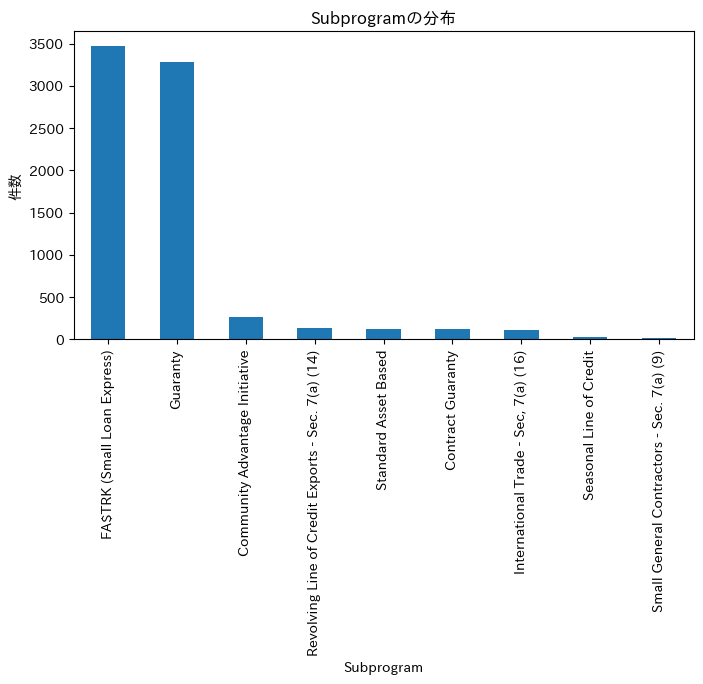

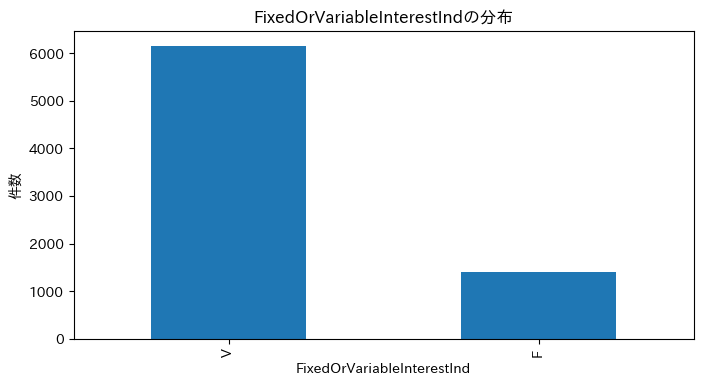

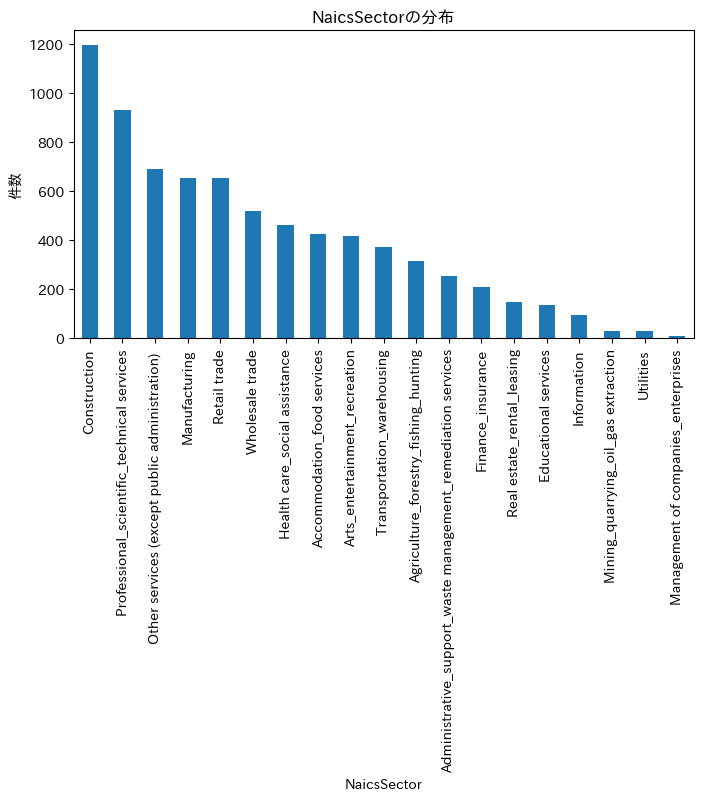

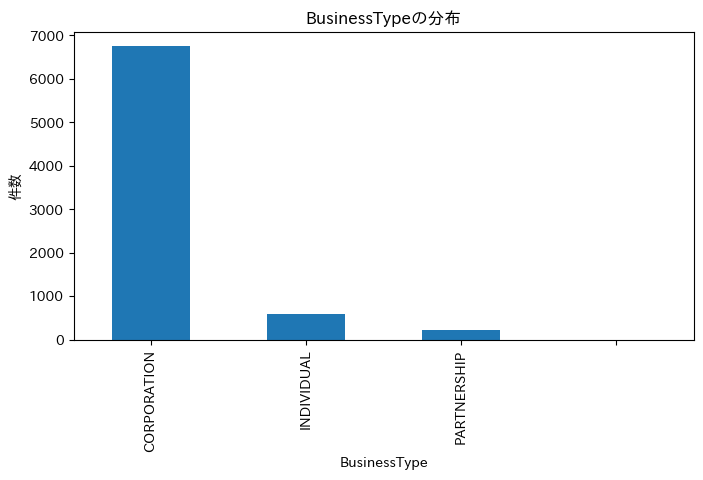

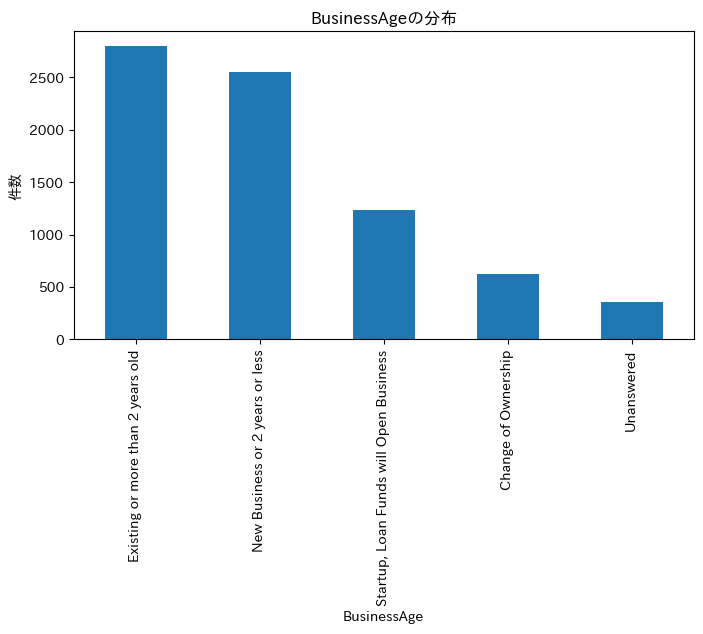

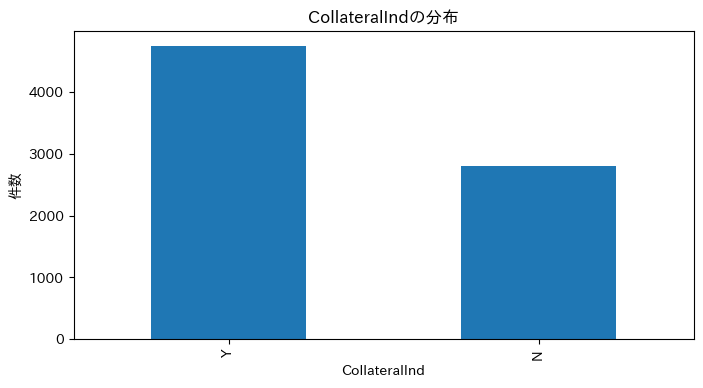

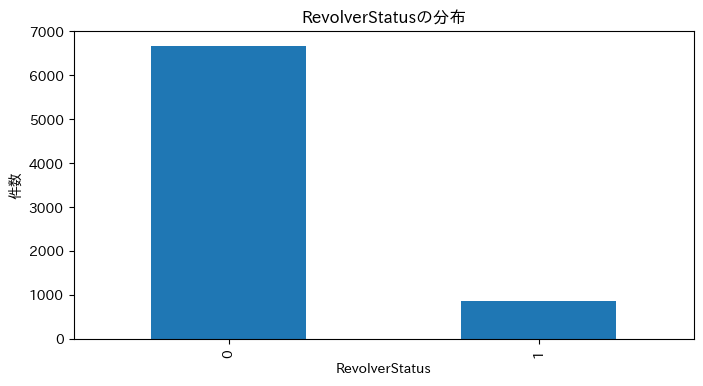

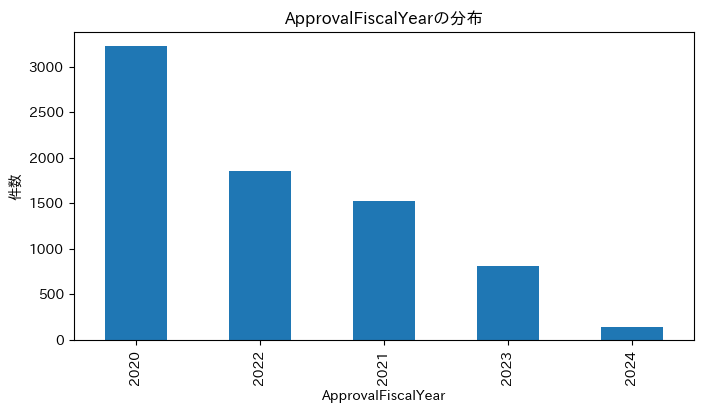

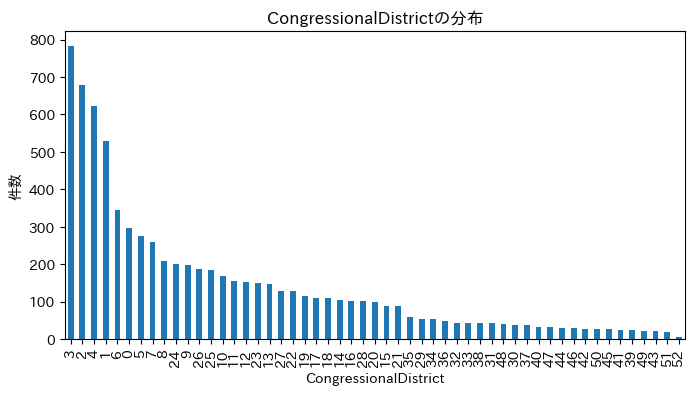

In [20]:
cat_cols = train.select_dtypes(include=['object']).columns.tolist() + ['RevolverStatus'] + ['ApprovalFiscalYear'] + ['CongressionalDistrict']
for col in cat_cols:
    plt.figure(figsize=(8,4))
    train[col].value_counts().plot(kind='bar')
    plt.title(f'{col}の分布')
    plt.ylabel('件数')
    plt.show()

# カテゴリ変数の分布を１つのCSVにまとめる
cat_counts = {}
for col in cat_cols:
    counts = train[col].value_counts()
    for index, count in counts.items():
        if col not in cat_counts:
            cat_counts[col] = {}
        cat_counts[col][index] = count
cat_counts_df = pd.DataFrame(cat_counts).T.fillna(0).astype(int)
cat_counts_df.to_csv('../data/understand/cat_counts.csv')

# 数値特徴量の相関関係

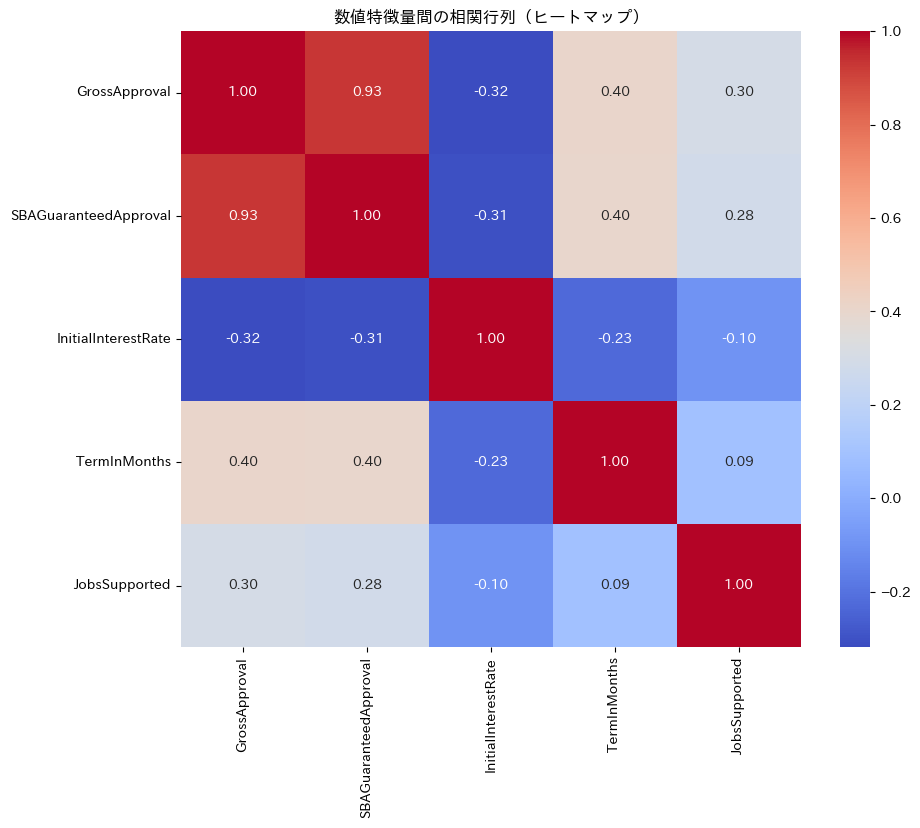

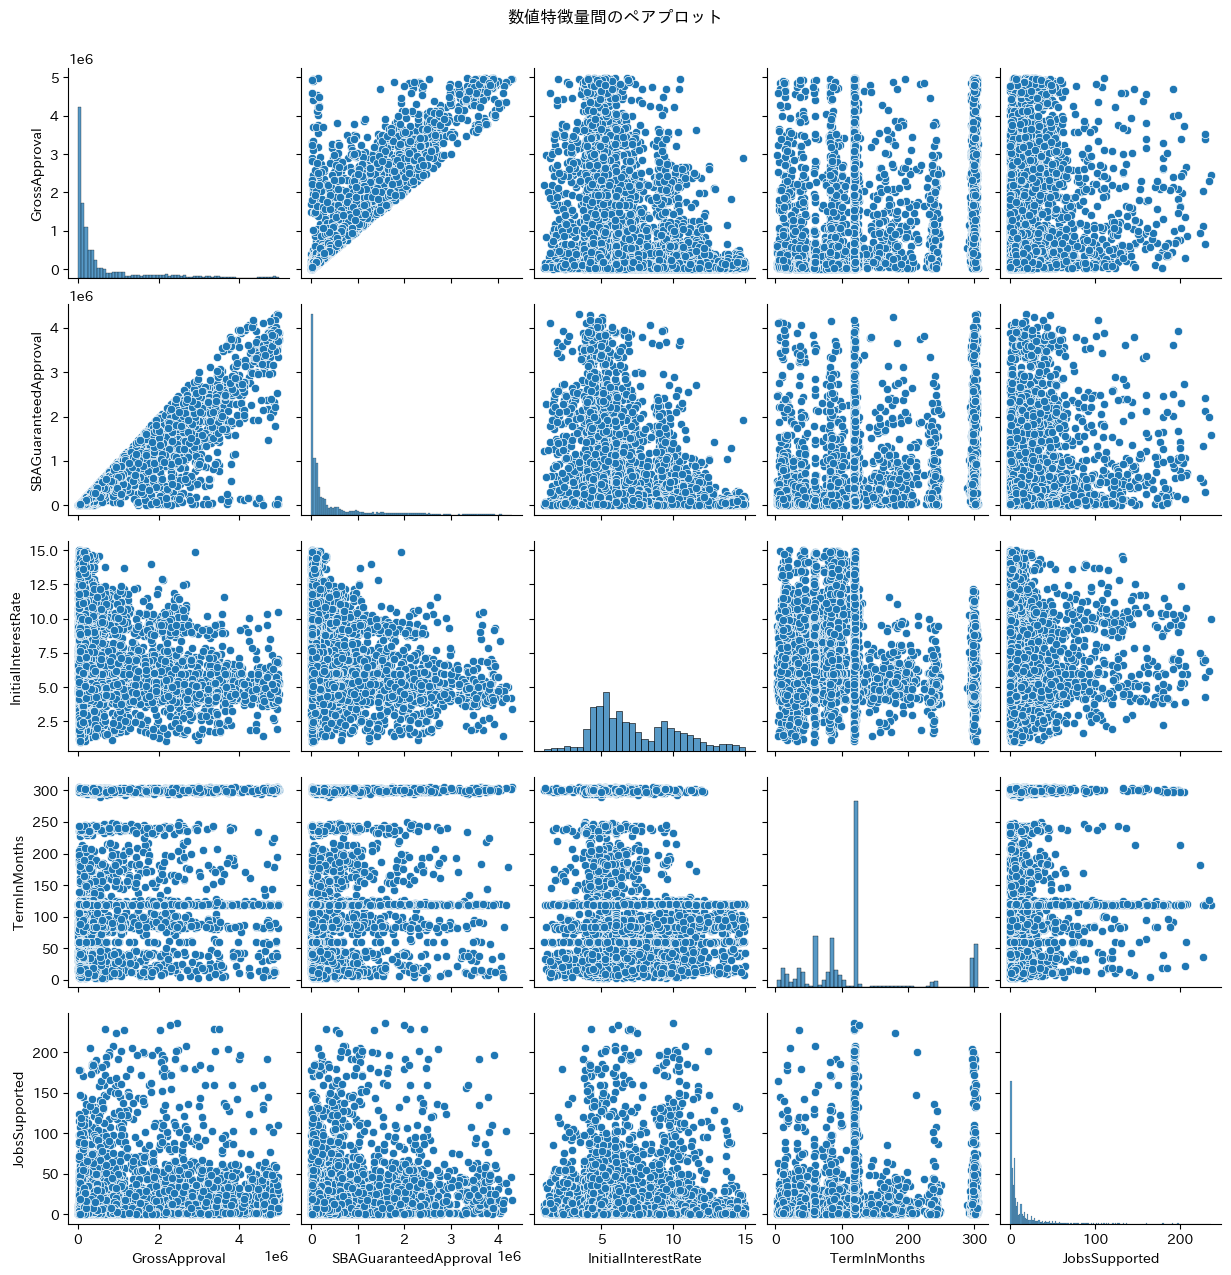

In [21]:
# 特徴量間の相関関係の可視化
corr = train[num_cols].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('数値特徴量間の相関行列（ヒートマップ）')
plt.show()

# ペアプロット（数値特徴量間の散布図行列）
sns.pairplot(train[num_cols])
plt.suptitle('数値特徴量間のペアプロット', y=1.02)
plt.show()

# AIが解釈できるようにCSVファイルに数値特徴量間の相関行列を保存
corr.to_csv('../data/understand/数値特徴量間の相関行列.csv')


# カテゴリ変数と目的変数の関係

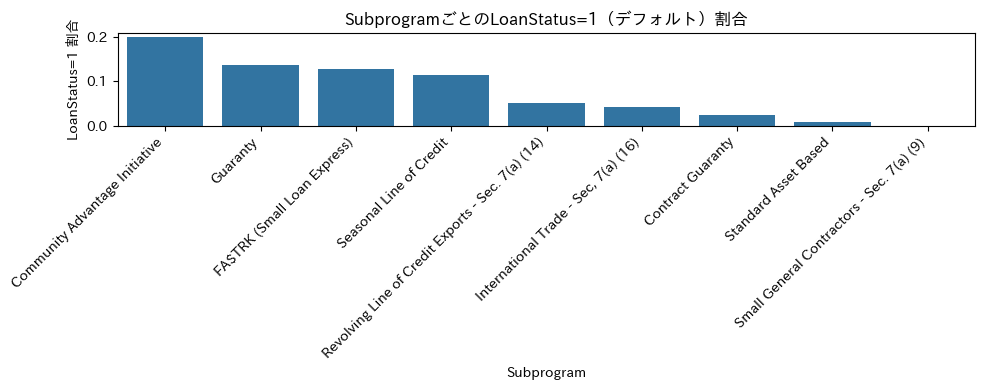

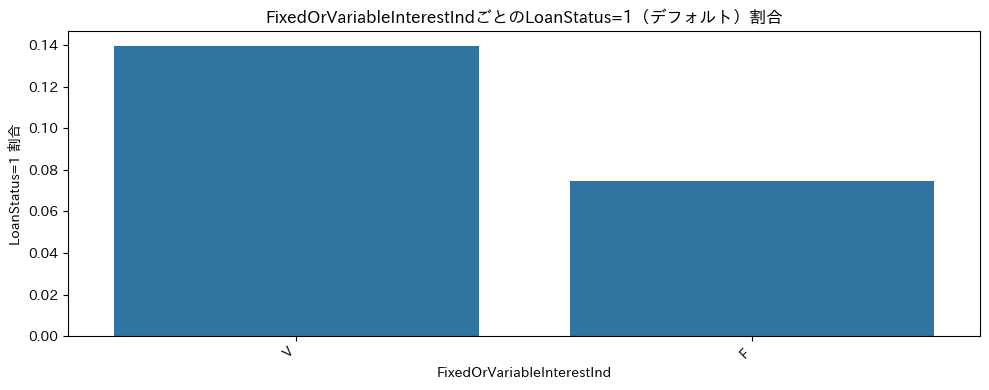

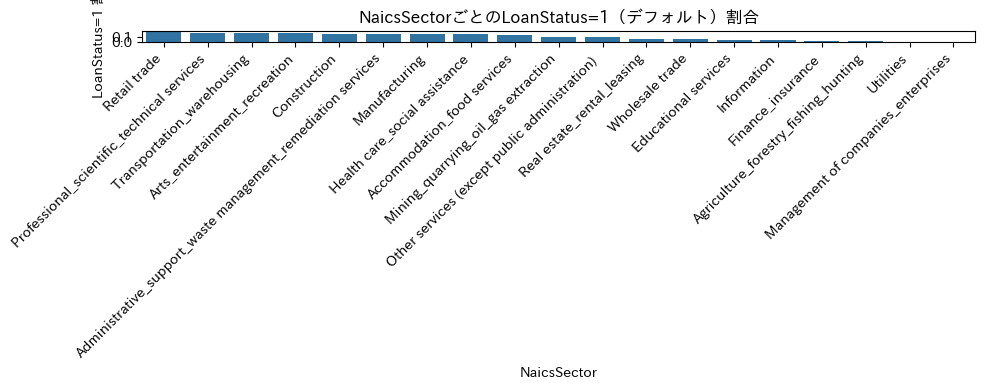

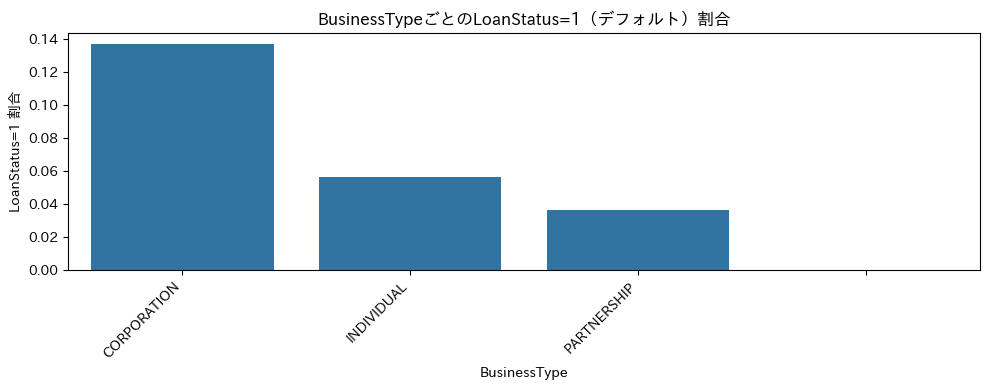

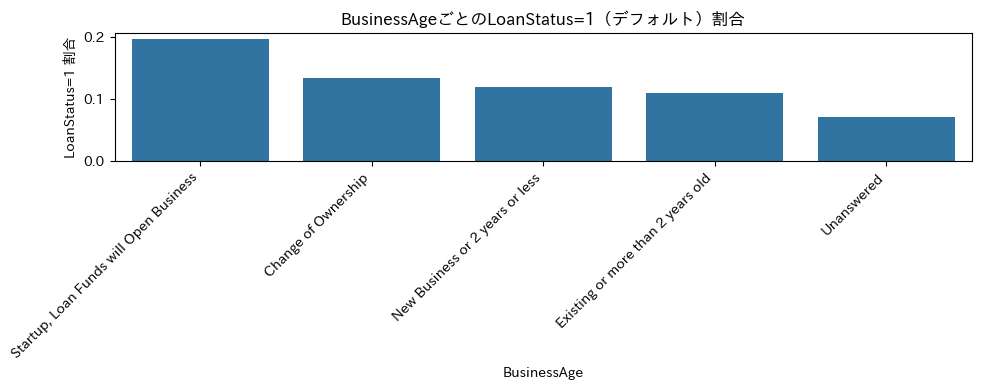

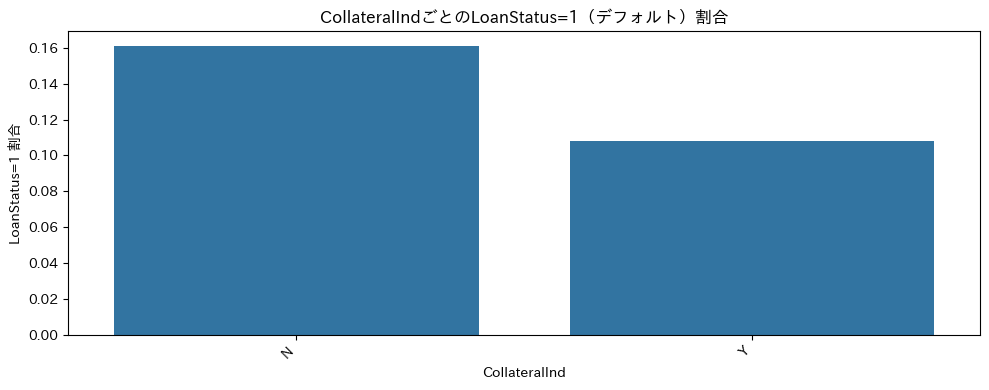

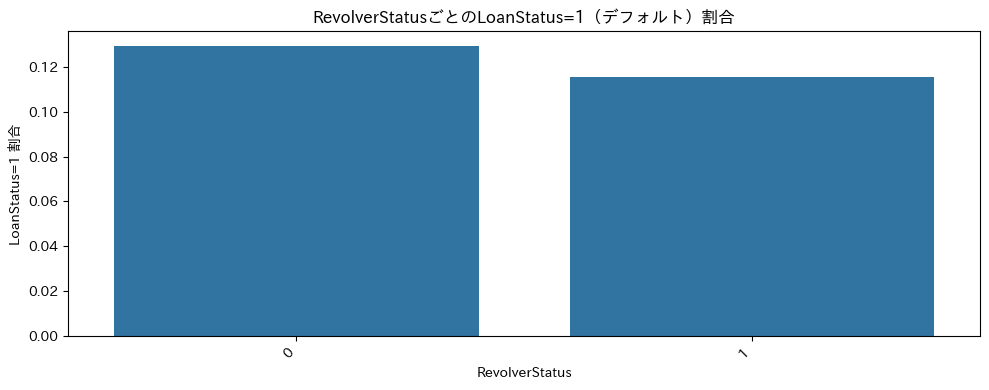

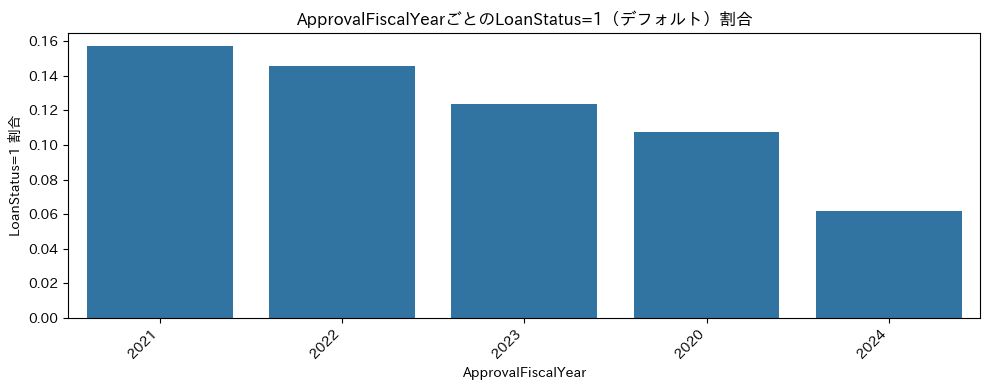

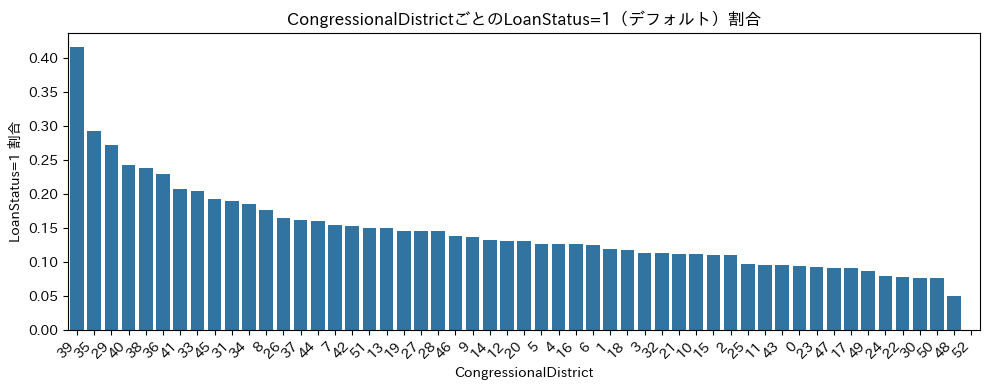

In [22]:
results = []
for col in cat_cols:
    # 各カテゴリごとにLoanStatus=1の割合を計算
    ratio_df = train.groupby(col)['LoanStatus'].mean().reset_index()
    ratio_df.columns = [col, 'LoanStatus=1_ratio']
    results.append(ratio_df)
    
    # グラフ化
    plt.figure(figsize=(10,4))
    sns.barplot(x=col, y='LoanStatus=1_ratio', data=ratio_df, order=ratio_df.sort_values('LoanStatus=1_ratio', ascending=False)[col])
    plt.title(f'{col}ごとのLoanStatus=1（デフォルト）割合')
    plt.ylabel('LoanStatus=1 割合')
    plt.xlabel(col)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# 全カテゴリ変数の割合を1つのCSVにまとめて出力
all_ratios = pd.concat(results, axis=0, ignore_index=True)
all_ratios.to_csv('../data/understand/カテゴリ変数とLoanStatusの関係.csv', index=False)

# 異常値・外れ値の検出

In [23]:
# 異常値・外れ値の検出
from scipy.stats import zscore

outlier_info = {}
for col in num_cols:
    # IQRによる外れ値
    Q1 = train[col].quantile(0.25)
    Q3 = train[col].quantile(0.75)
    IQR = Q3 - Q1
    iqr_outliers = train[(train[col] < Q1 - 1.5 * IQR) | (train[col] > Q3 + 1.5 * IQR)][col]
    # Zスコアによる異常値
    z_outliers = train[np.abs(zscore(train[col])) > 3][col]
    outlier_info[col] = {
        'IQR_outlier_count': iqr_outliers.shape[0],
        'IQR_outlier_values': iqr_outliers.values,
        'Z_outlier_count': z_outliers.shape[0],
        'Z_outlier_values': z_outliers.values
    }

outlier_summary = pd.DataFrame([
    {
        'feature': col,
        'IQR_outlier_count': info['IQR_outlier_count'],
        'Z_outlier_count': info['Z_outlier_count']
    }
    for col, info in outlier_info.items()
])
outlier_summary.to_csv('../data/understand/数値特徴量の外れ値・異常値件数.csv', index=False)
# 件数を表示
print(outlier_summary)


                 feature  IQR_outlier_count  Z_outlier_count
0          GrossApproval               1055              202
1  SBAGuaranteedApproval                995              208
2    InitialInterestRate                  0                0
3           TermInMonths               1189                0
4          JobsSupported                788              210


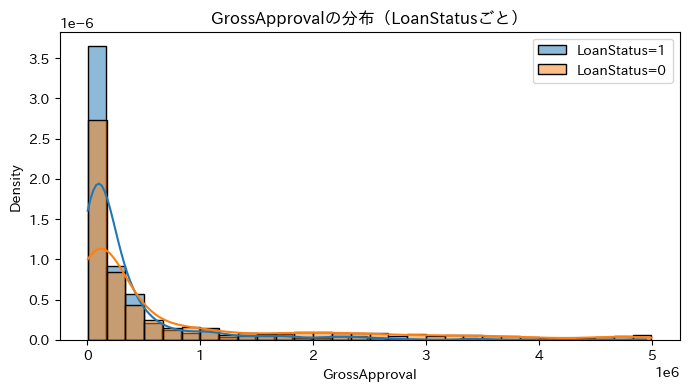

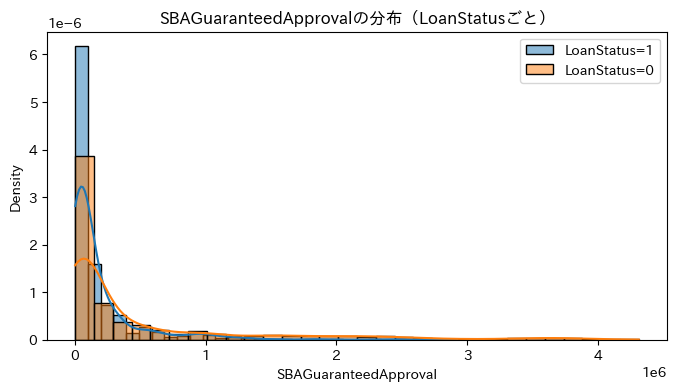

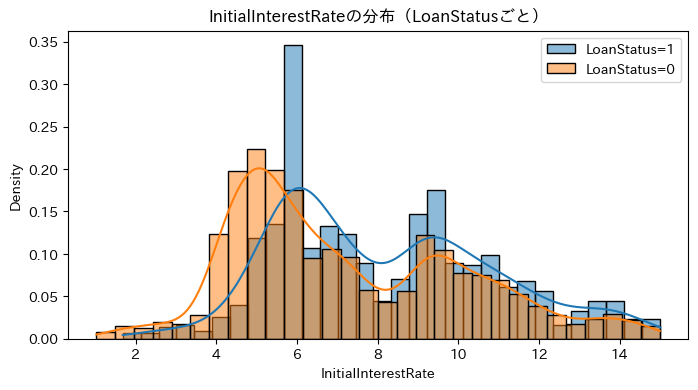

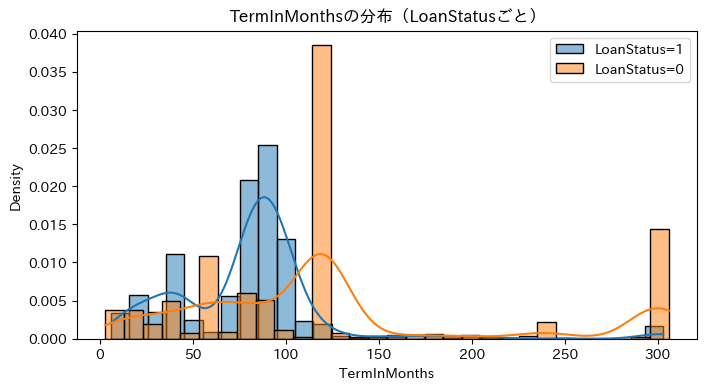

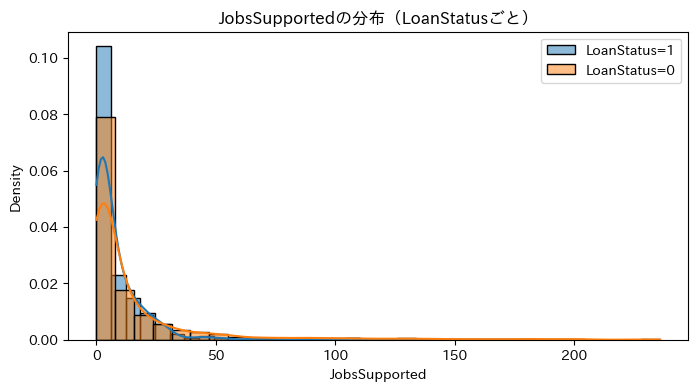

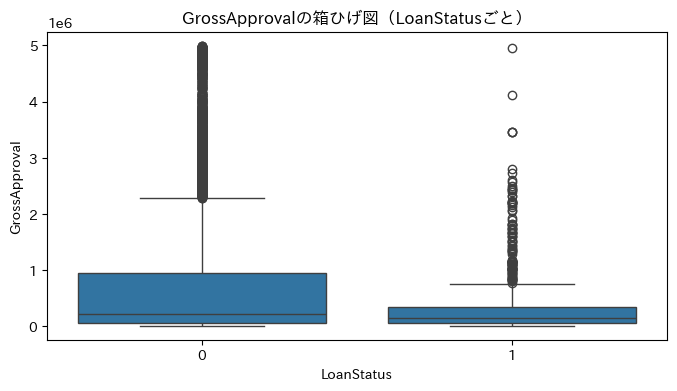

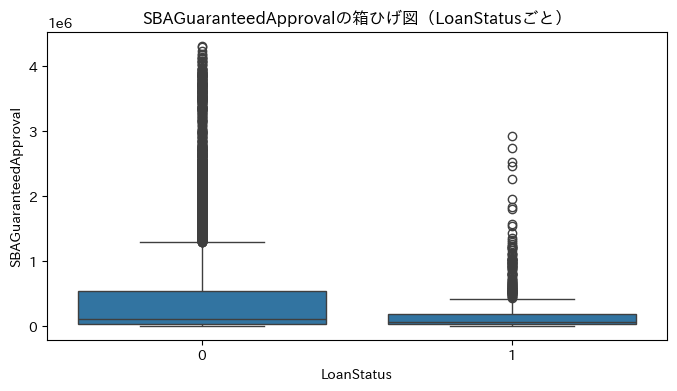

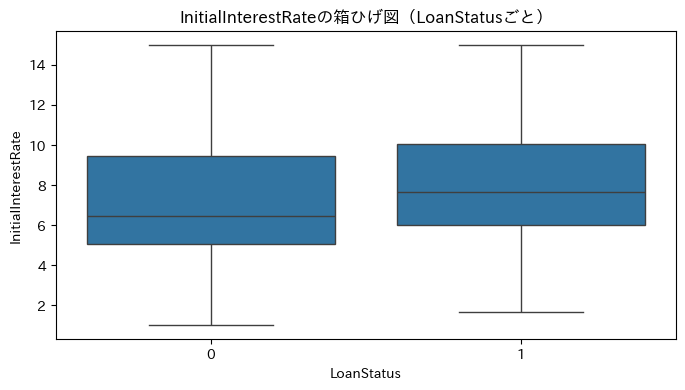

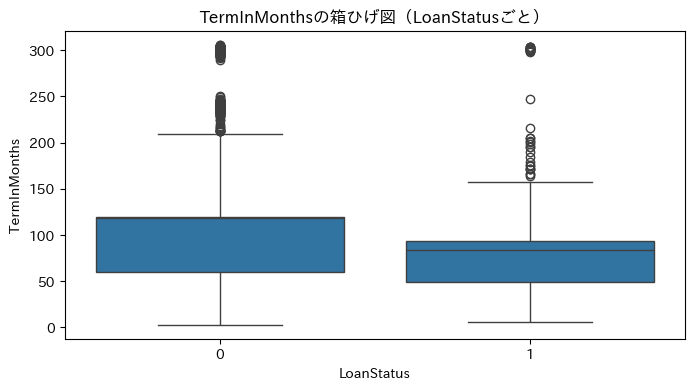

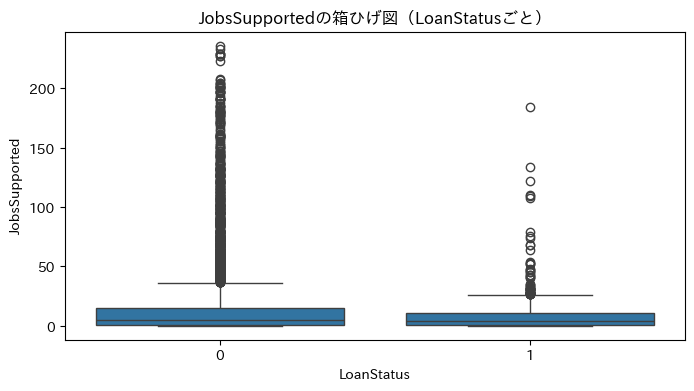

In [24]:
# 目的変数ごとに特徴量分布の比較
for col in num_cols:
    plt.figure(figsize=(8,4))
    for label in train['LoanStatus'].unique():
        subset = train[train['LoanStatus'] == label]
        sns.histplot(subset[col], label=f'LoanStatus={label}', kde=True, stat='density', bins=30)
    plt.title(f'{col}の分布（LoanStatusごと）')
    plt.legend()
    plt.show()

for col in num_cols:
    plt.figure(figsize=(8,4))
    sns.boxplot(x='LoanStatus', y=col, data=train)
    plt.title(f'{col}の箱ひげ図（LoanStatusごと）')
    plt.show()

## 重要そうな特徴量の仮説

- 融資承認額（GrossApproval）や補償金額（SBAGuaranteedApproval）は返済能力に影響しそう
- 初期金利（InitialInterestRate）が高いほどデフォルトリスクが高まる可能性
- 融資期間（TermInMonths）が長い場合、返済リスクが高まるかも
- 業種（NaicsSector）や事業形態（BusinessType）によって返済傾向が異なる可能性
- 担保の有無（CollateralInd）や事業年数（BusinessAge）も重要な要素と考えられる

train columns: ['id', 'GrossApproval', 'SBAGuaranteedApproval', 'ApprovalFiscalYear', 'Subprogram', 'InitialInterestRate', 'FixedOrVariableInterestInd', 'TermInMonths', 'NaicsSector', 'CongressionalDistrict', 'BusinessType', 'BusinessAge', 'RevolverStatus', 'JobsSupported', 'CollateralInd', 'LoanStatus']
test columns: ['id', 'GrossApproval', 'SBAGuaranteedApproval', 'ApprovalFiscalYear', 'Subprogram', 'InitialInterestRate', 'FixedOrVariableInterestInd', 'TermInMonths', 'NaicsSector', 'CongressionalDistrict', 'BusinessType', 'BusinessAge', 'RevolverStatus', 'JobsSupported', 'CollateralInd']


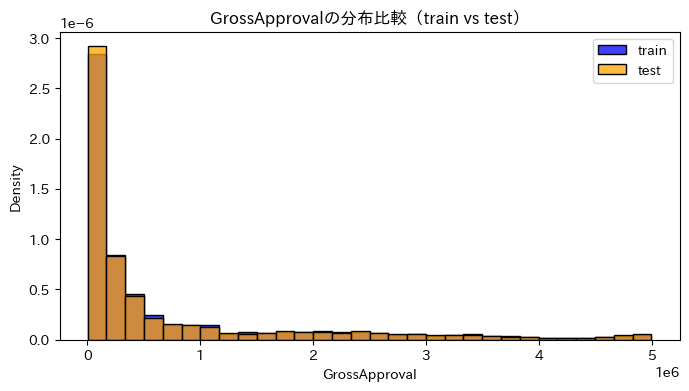

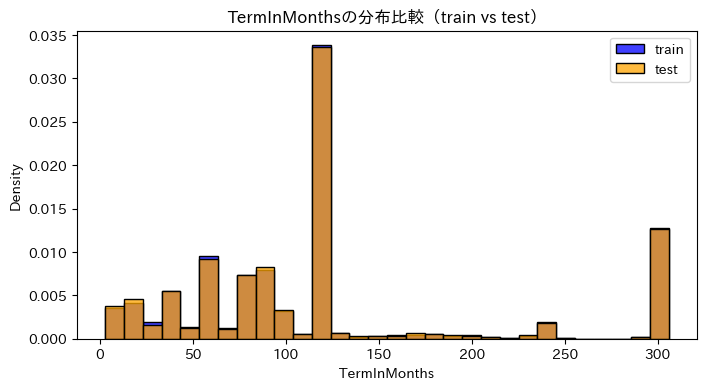

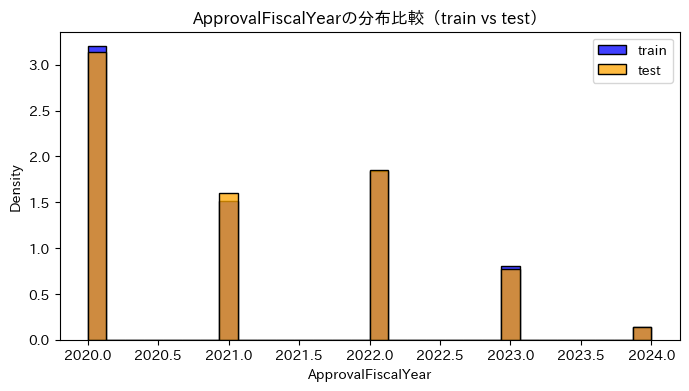

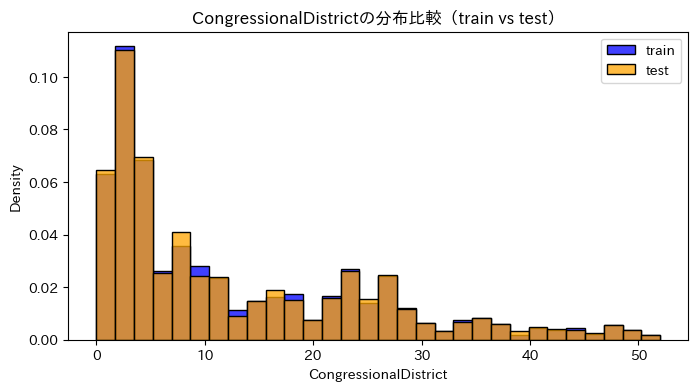

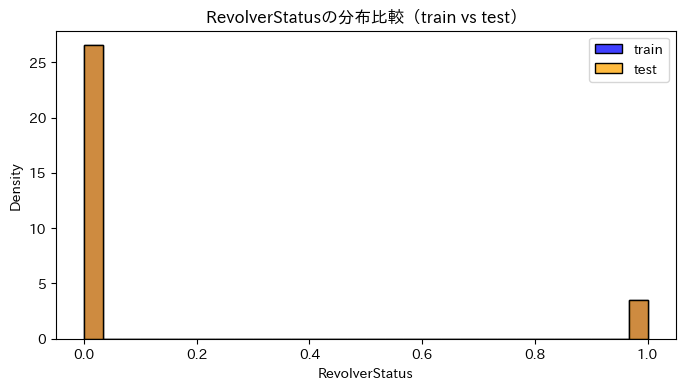

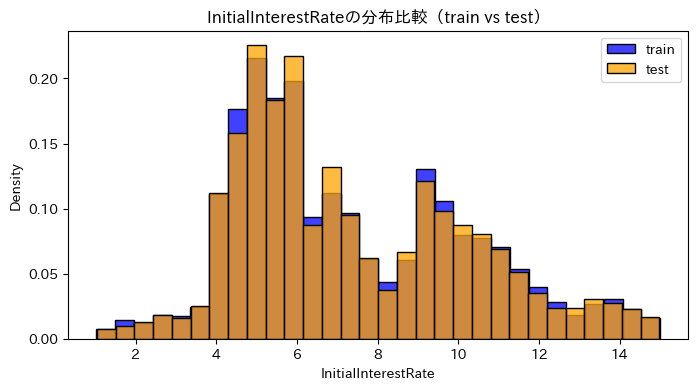

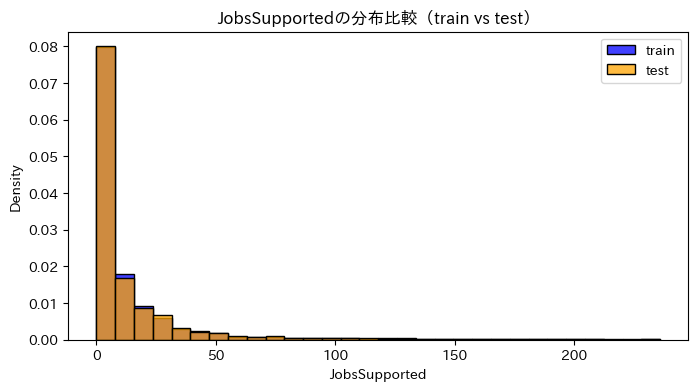

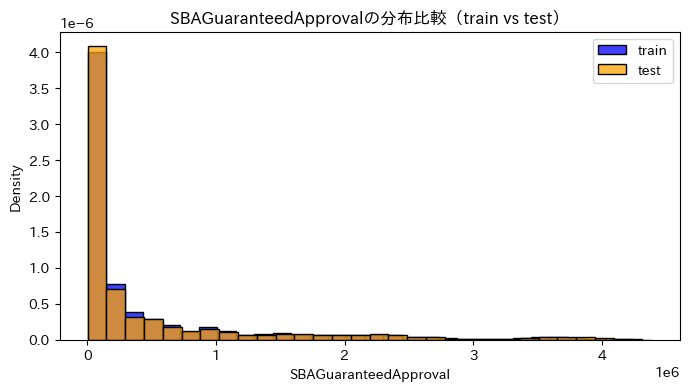

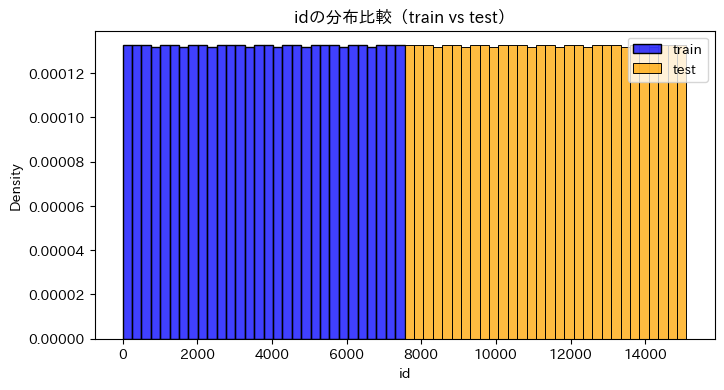

In [25]:
# train.csvとtest.csvの違い確認
print('train columns:', train.columns.tolist())
print('test columns:', test.columns.tolist())

# 共通特徴量の分布比較
for col in set(train.columns) & set(test.columns):
    if train[col].dtype in [np.int64, np.float64]:
        plt.figure(figsize=(8,4))
        sns.histplot(train[col], color='blue', label='train', stat='density', bins=30)
        sns.histplot(test[col], color='orange', label='test', stat='density', bins=30)
        plt.title(f'{col}の分布比較（train vs test）')
        plt.legend()
        plt.show()

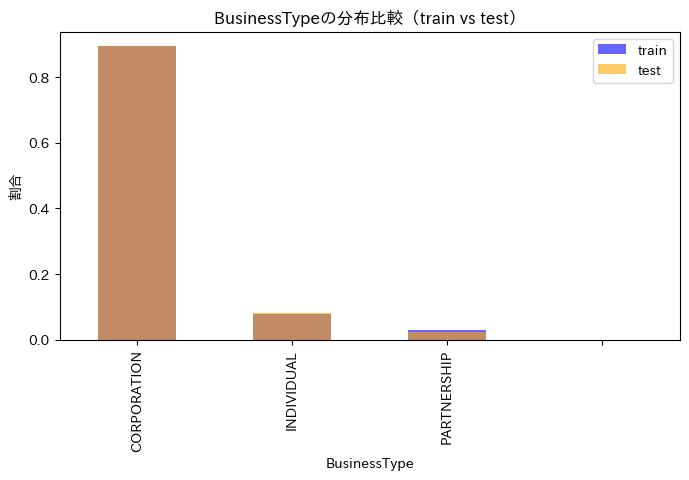

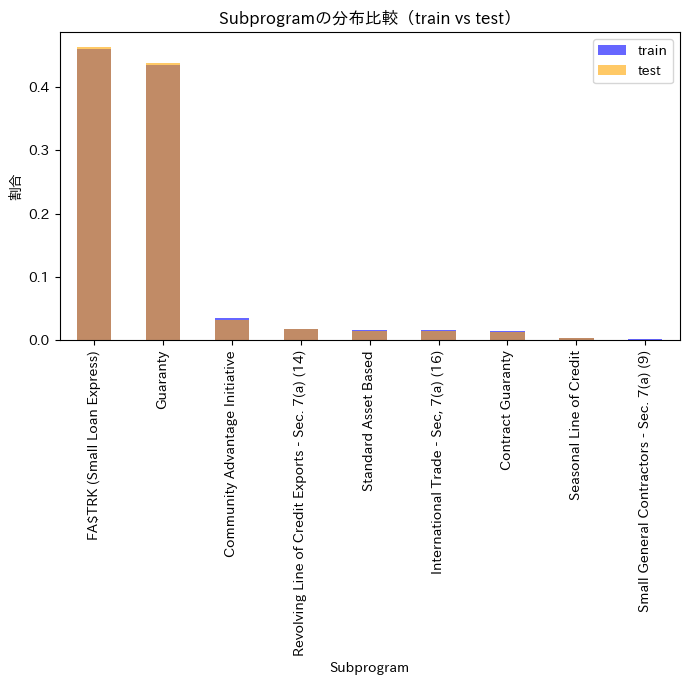

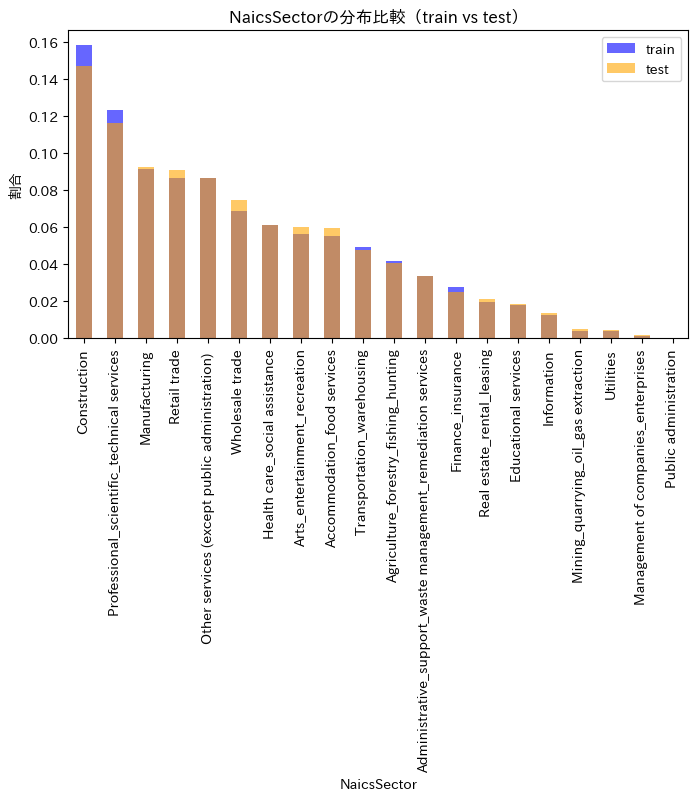

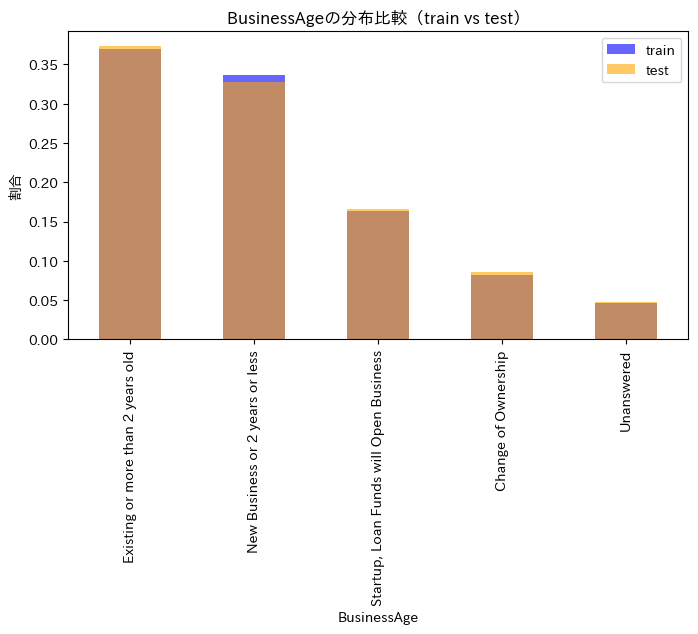

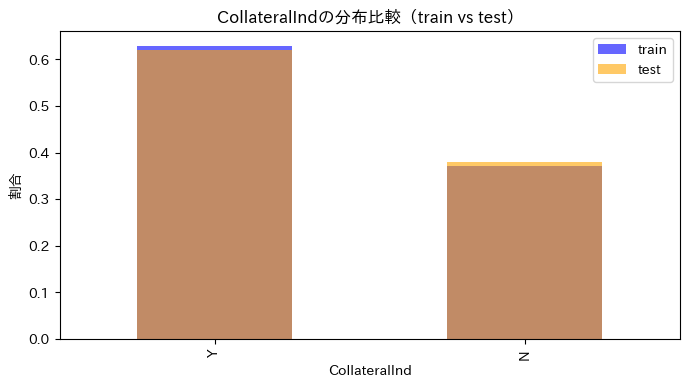

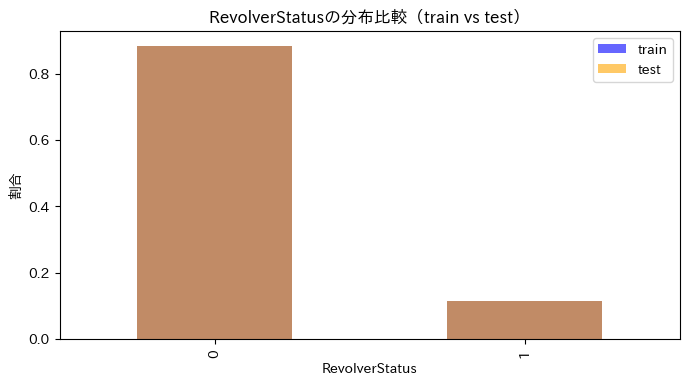

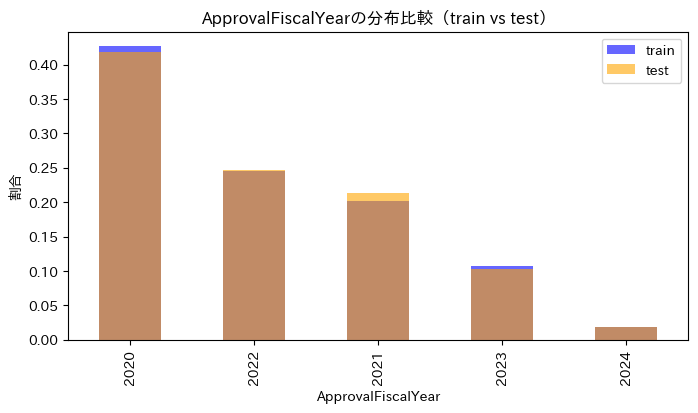

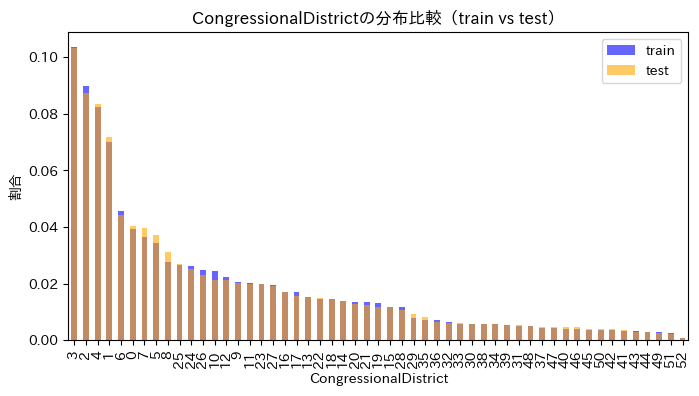

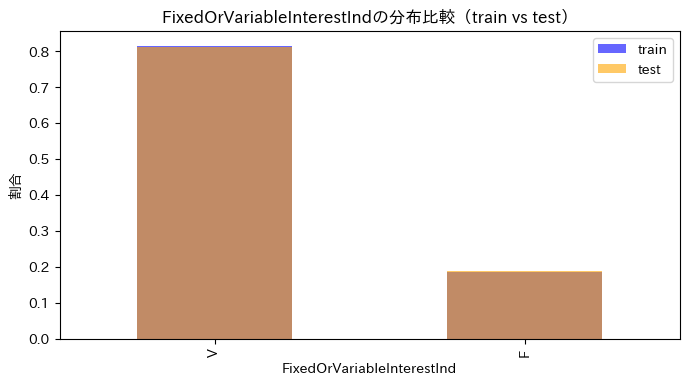

In [26]:
# カテゴリ変数についても、trainとtestの分布を比較
for col in set(cat_cols) & set(test.columns):
    plt.figure(figsize=(8,4))
    train[col].value_counts(normalize=True).plot(kind='bar', color='blue', alpha=0.6, label='train')
    test[col].value_counts(normalize=True).plot(kind='bar', color='orange', alpha=0.6, label='test')
    plt.title(f'{col}の分布比較（train vs test）')
    plt.ylabel('割合')
    plt.legend()
    plt.show()